<a href="https://colab.research.google.com/github/ibader85/UnstructuredDataAnalytics/blob/main/09_K_Means_Cluster_Analysis_Pokemon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

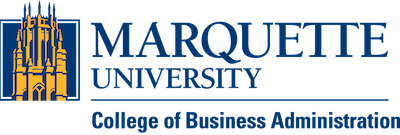

#BUAN4060: Unstructured Data Analytics

##09 K-Means Cluster Analysis - Pokemon

##Instructor: Dr. Badar Al Lawati "Dr. B"

**Acknowledgment:** This material is based on the content created by `Prof. Timothy E. Carone`

**R on Colab:**

* You can change the runtime from Python to R, by clicking on the down arrow next to Connect, and picking "Change Runtime Type"

* You can change the project name by clicking on the title on top of this page

* You can export your notebook by going to File > Download .ipynb



##1. Pokemon (k-means cluster analysis)

**Workflow:**
1. Prepare the data
2. Select the features (variables) to use for clustering
3. Scale data to a shared space if the featured used are on different scales
4. Determine the number of clusters
5. Fit an optimal model. 6. Evaluate results (including visualization)

**Goal of the analysis:** The main challange with this data is that there is no predetermined number of clusters. We will use the 6 attributes (i.e. features):
- “HP”
- “Attack”
- “Defense”
- “Speed”
- “Special Attack”
- “Special Defense”

to determine the optimnal number of clusters and assign each of the 800 pokemon to a cluster

## 2. Data preparation

Before we can do the cluster analysis we need to prepare the data. This means loading the data, exploring it and converting it into a matrix

In [1]:
install.packages ("dplyr")
library(dplyr)
Pokemon <- read.csv("Pokemon.csv") %>% rename(SpecialAttack = "Sp..Atk",SpecialDefense = "Sp..Def")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
# Quick overview of data
head(Pokemon)

,X.,Name,Type.1,Type.2,Total,HP,Attack,Defense,SpecialAttack,SpecialDefense,Speed,Generation,Legendary
,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
1,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
2,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
3,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
4,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
5,4,Charmander,Fire,,309,39,52,43,60,50,65,1,False
6,5,Charmeleon,Fire,,405,58,64,58,80,65,80,1,False


In [3]:
Pokemon%>%
distinct(Name)%>% # filter the dataset to keep only distinct rows based on the "Name" column
tally()%>% # count the number of rows in the filtered dataset, which is equivalent to the number of distinct Pokémon names
unlist() # function is used to extract the count from the resulting tibble, converting it to a simple numeric value

n 
800

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



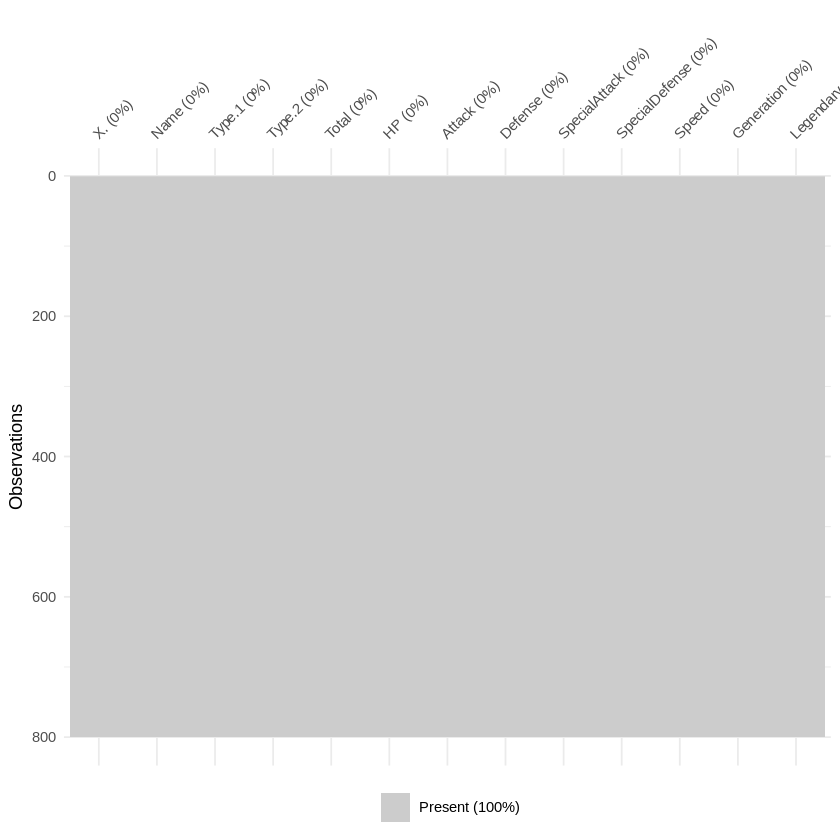

In [4]:
# Check if there are missing values (NA)
# Install vis_miss using devtools::install_github("ropensci/visdat")
install.packages("visdat")
library(visdat)
vis_miss(Pokemon) # used to visualize missing data in a dataset

A quick look at the data tells us that it contains observations for 800 distinct pokemons and no missing values. Each pokemon is characterised by a set of 6 features (numeric variables) that we can use for clustering.

### Feature selection

Select the features (variables) to use for clustering and convert the data frame into a matrix.

In [5]:
# Select relevant feature columns
PokeSelection <- Pokemon%>%
select(Name, HP, Attack, Defense, Speed, SpecialAttack, SpecialDefense)

# Convert to matrix and use scale() to center and scale columns
PokeMatrix <- as.matrix(PokeSelection[,-1]) # exclude the first column ("Name") from the "PokeSelection" data frame

# Add pokemon names
rownames(PokeMatrix) <- Pokemon$Name # assign the values from the "Name" column of the "Pokemon" data frame as the row names of the "PokeMatrix" matrix
                                     # The rownames() function is used to set the row names of the matrix to the values provided in Pokemon$Name

head(PokeMatrix)

,HP,Attack,Defense,Speed,SpecialAttack,SpecialDefense
Bulbasaur,45,49,49,45,65,65
Ivysaur,60,62,63,60,80,80
Venusaur,80,82,83,80,100,100
VenusaurMega Venusaur,80,100,123,80,122,120
Charmander,39,52,43,65,60,50
Charmeleon,58,64,58,80,80,65


## 2.1 Scale data

If any of the features are on different scales it is recommended to scale all features so that they have the same mean and standard deviation

In [6]:
# Check if you need to scale the data

# Return mean valume for each feature
mean_sd <- cbind(as.data.frame # The cbind function is used to combine the two data frames into a single data frame with two columns: "Mean" and "SD"
                               # convert the calculated mean and standard deviation vectors into data frames

(colMeans(PokeMatrix)), # calculate the column means of the "PokeMatrix" matrix, resulting in a vector of mean values for each column

  as.data.frame(apply(PokeMatrix, 2, sd))) # calculate the standard deviation (SD) for each column of the "PokeMatrix"
                                          # The argument 2 specifies that the operation should be applied to columns

colnames(mean_sd) <- c("Mean","SD")

mean_sd

,Mean,SD
,<dbl>,<dbl>
HP,69.25875,25.53467
Attack,79.00125,32.45737
Defense,73.84250,31.18350
Speed,68.27750,29.06047
SpecialAttack,72.82000,32.72229
SpecialDefense,71.90250,27.82892


We need to scale the data

In [7]:
# scale data using the scale() function
PokeMatrix_scaled <- scale(PokeMatrix) # The scale function is used to standardize the columns of the "PokeMatrix"

# Check if scaling worked
mean_sd_norm <- cbind(as.data.frame(colMeans(PokeMatrix_scaled)),  as.data.frame(apply(PokeMatrix_scaled, 2, sd)))
colnames(mean_sd_norm) <- c("Mean_scaled","SD_scaled")

mean_sd_norm

,Mean_scaled,SD_scaled
,<dbl>,<dbl>
HP,-2.517214e-16,1
Attack,3.446896e-17,1
Defense,-3.948231e-17,1
Speed,-1.102547e-16,1
SpecialAttack,2.097498e-16,1
SpecialDefense,-1.274306e-16,1


### Model selection

To fit an accurate model, we first need to determine the appropriate number of clusters. For this we will fit 10 different models that contain 1 to 10 clusters. For each of the models we will calculate the total within sum of squares and plot it against the number of clusters. This will allow us to look for the “elbow” in the plot and determine the optimal number of clusters for this data set.

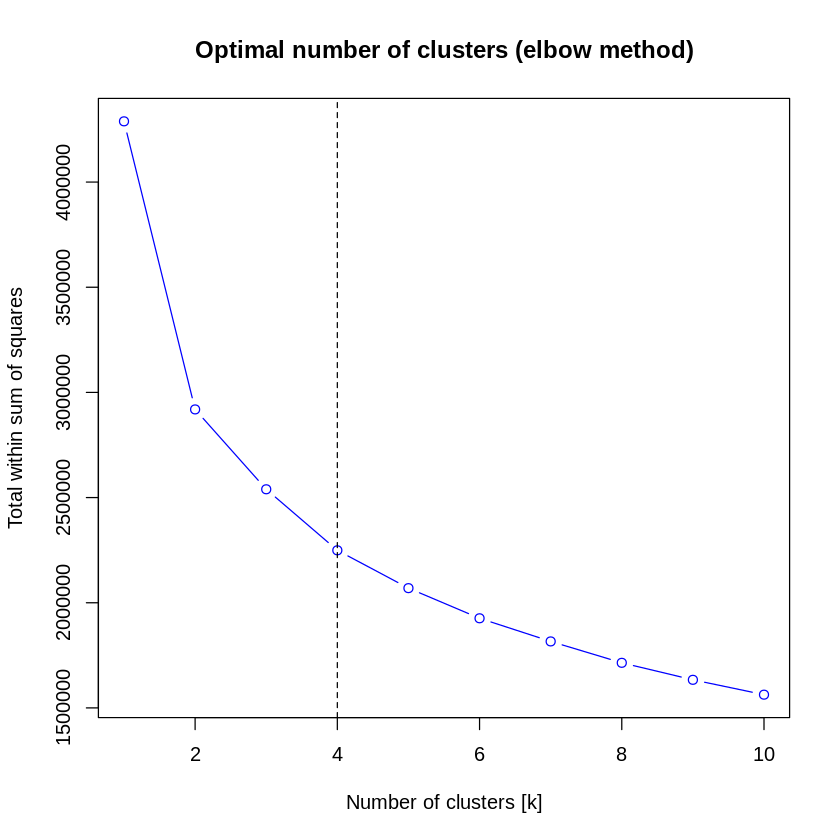

In [8]:
# Initialize total within sum of squares error (Cluster_wss)
cluster_wss <- 0 # initializ the variable cluster_wss with a value of 0

# Define a loop that runs kmeans() for 1 to 10 clusters
for (i in 1:10) {
  # Fit model
  PokeClusters <- kmeans(PokeMatrix,
                   centers = i,
                   nstart = 20,
                   iter.max = 50)
  # Save the within cluster sum of squares of each model
  cluster_wss[i] <- PokeClusters$tot.withinss
}

# Plot the number of clusters vs. total within sum of squares
plot(1:10, cluster_wss, type = "b",
     xlab = "Number of clusters [k]",
     ylab = "Total within sum of squares", col = "blue",
     main = "Optimal number of clusters (elbow method)")
     abline(v=4, col="black", lty = 2)

As with many real life data sets in this scree plot the so called “elbow” is not clearly visible. Based on this plot we will decide that 4 is a reasonable number of clusters for this analysis.

## 2.2 Fit a model with optimal cluster numbers

In [9]:
# Set the number of clusters
k <- 4

# Build model using k clusters
set.seed(12334)
PokeClusters <- kmeans(PokeMatrix, centers = k, nstart = 20, iter.max = 50)

# View  model results
head(PokeClusters)

,HP,Attack,Defense,Speed,SpecialAttack,SpecialDefense
1,71.30435,92.91304,121.42609,52.36522,63.89565,88.23478
2,50.29682,54.03180,51.62898,49.74912,47.90459,49.15548
3,89.20175,121.09649,92.73684,100.44737,120.45614,97.67544
4,79.18056,81.31944,69.19097,80.10417,82.01042,77.53125


### Evaluation of clustering

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Deriv’, ‘microbenchmark’, ‘doBy’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘lazyeval’, ‘carData’, ‘Formula’, ‘pbkrtest’, ‘quantreg’, ‘lme4’, ‘crosstalk’, ‘estimability’, ‘numDeriv’, ‘mvtnorm’, ‘corrplot’, ‘viridis’, ‘car’, ‘DT’, ‘ellipse’, ‘emmeans’, ‘flashClust’, ‘leaps’, ‘multcompView’, ‘scatterplot3d’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘gridExtra’, ‘polynom’, ‘rstatix’, ‘plyr’, ‘abind’, ‘dendextend’, ‘FactoMineR’, ‘ggpubr’, ‘reshape2’, ‘ggrepel’


Loading required package: ggplot2

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



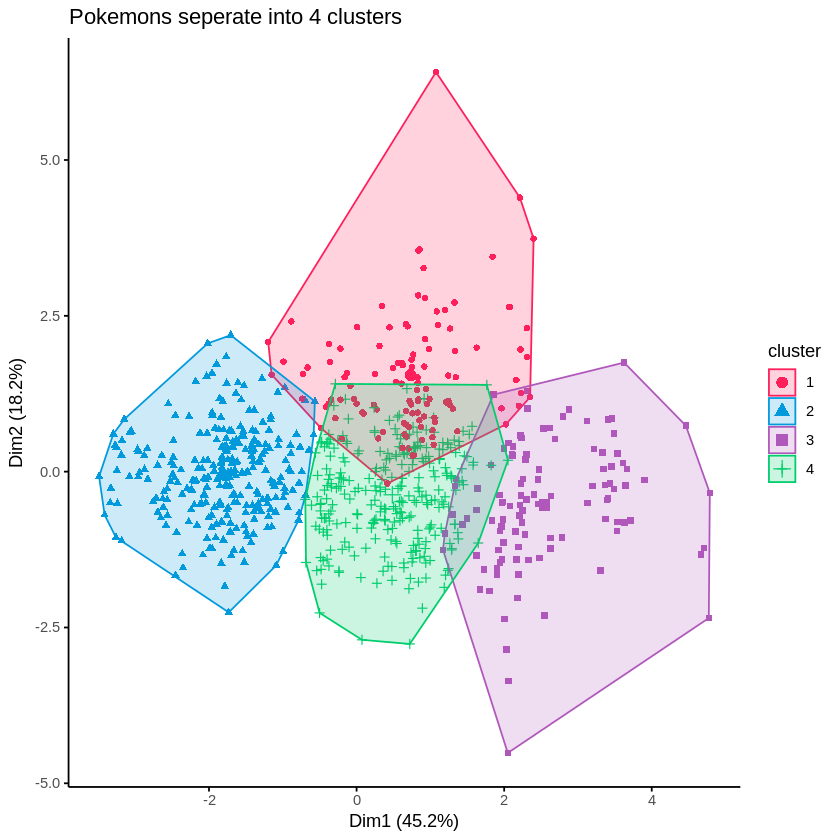

In [10]:
install.packages("factoextra") # used for visualizing multivariate data analysis results, including cluster analysis
library(factoextra)
fviz_cluster(PokeClusters, data = PokeMatrix, # generate a visualization of the k-means clustering results
             palette = c('#FF1F5B','#009ADC','#AF58BA','#00CD6C'),
             geom = "point",
             show.clust.cent = TRUE,
             ellipse.type = "convex", # indicates that convex ellipses are drawn around clusters
             ggtheme = theme_classic(),
             main = "Pokemons seperate into 4 clusters"
             )

The plot shows that a model with k = 4 clusters nicely separates the 800 Pokemon into 4 clusters with little overlap.

## 2.3 Explore cluster structure

We will use the cluster information to label each Pokemon in the original data. Then we can explore the clusters by plotting the cluster membership vs Pokemon type and their primary attributes.

In [11]:
# Assign each Pokemon a cluster
Pokemon[,"Cluster"] <- PokeClusters$cluster
# add a new column named "Cluster" to the Pokemon data frame and populates it with the cluster assignments obtained from the k-means clustering analysis

How many Pokemons are in each cluster?

In [12]:
Pokemon%>%
group_by(Cluster)%>%
tally() # count the number of Pokemon in each cluster

Cluster,n
<int>,<int>
1,115
2,283
3,114
4,288


How is the cluster distribution across Pokemon types (Type.1)?

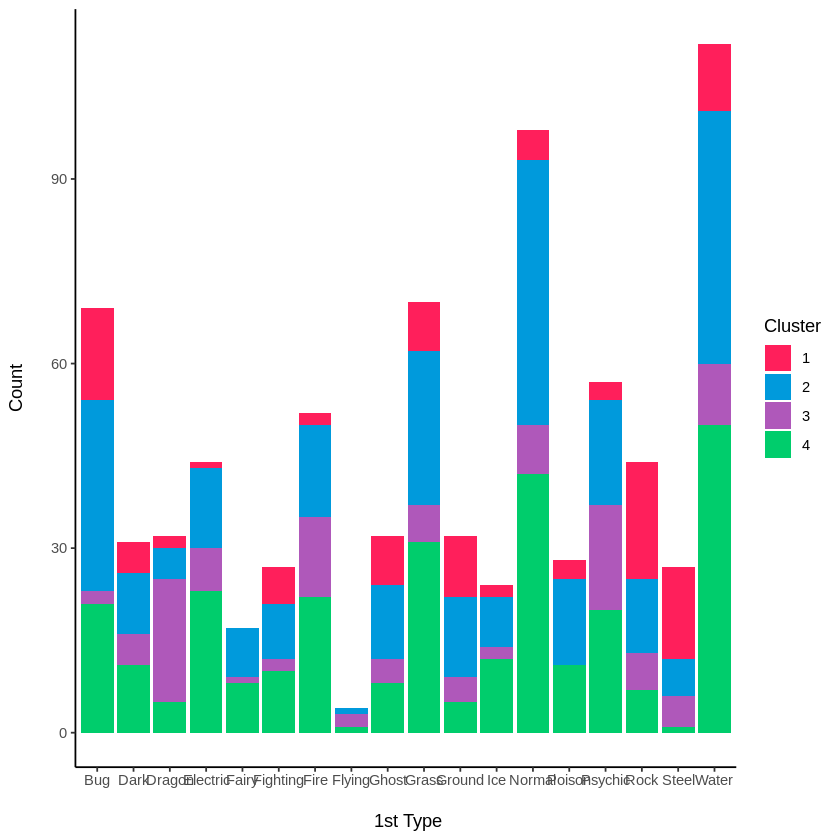

In [13]:
Pokemon%>%
group_by(Cluster,Type.1)%>%
tally() %>%
mutate(Cluster = as.factor(Cluster))%>%
ggplot(aes(x = as.factor(Type.1), y = n, fill = Cluster)) +
geom_bar(stat = "identity") +
  xlab("\n 1st Type") +
  ylab("Count\n") +
  theme_classic() +
 scale_fill_manual(values = c(
    '#FF1F5B',
    '#009ADC',
    '#AF58BA',
    '#00CD6C'
  ))

Plotting the cluster membership for Type.1 shows that all clusters are present across types with the exception of “Flying” that does not appear in cluster 1.

Which of the clusters contains the strongest/weakest Pokemon? Are there attributes that are associated with particular clusters?

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘beeswarm’


Warning message:
“The `fun.y` argument of `stat_summary()` is deprecated as of ggplot2 3.3.0.
ℹ Please use the `fun` argument instead.”


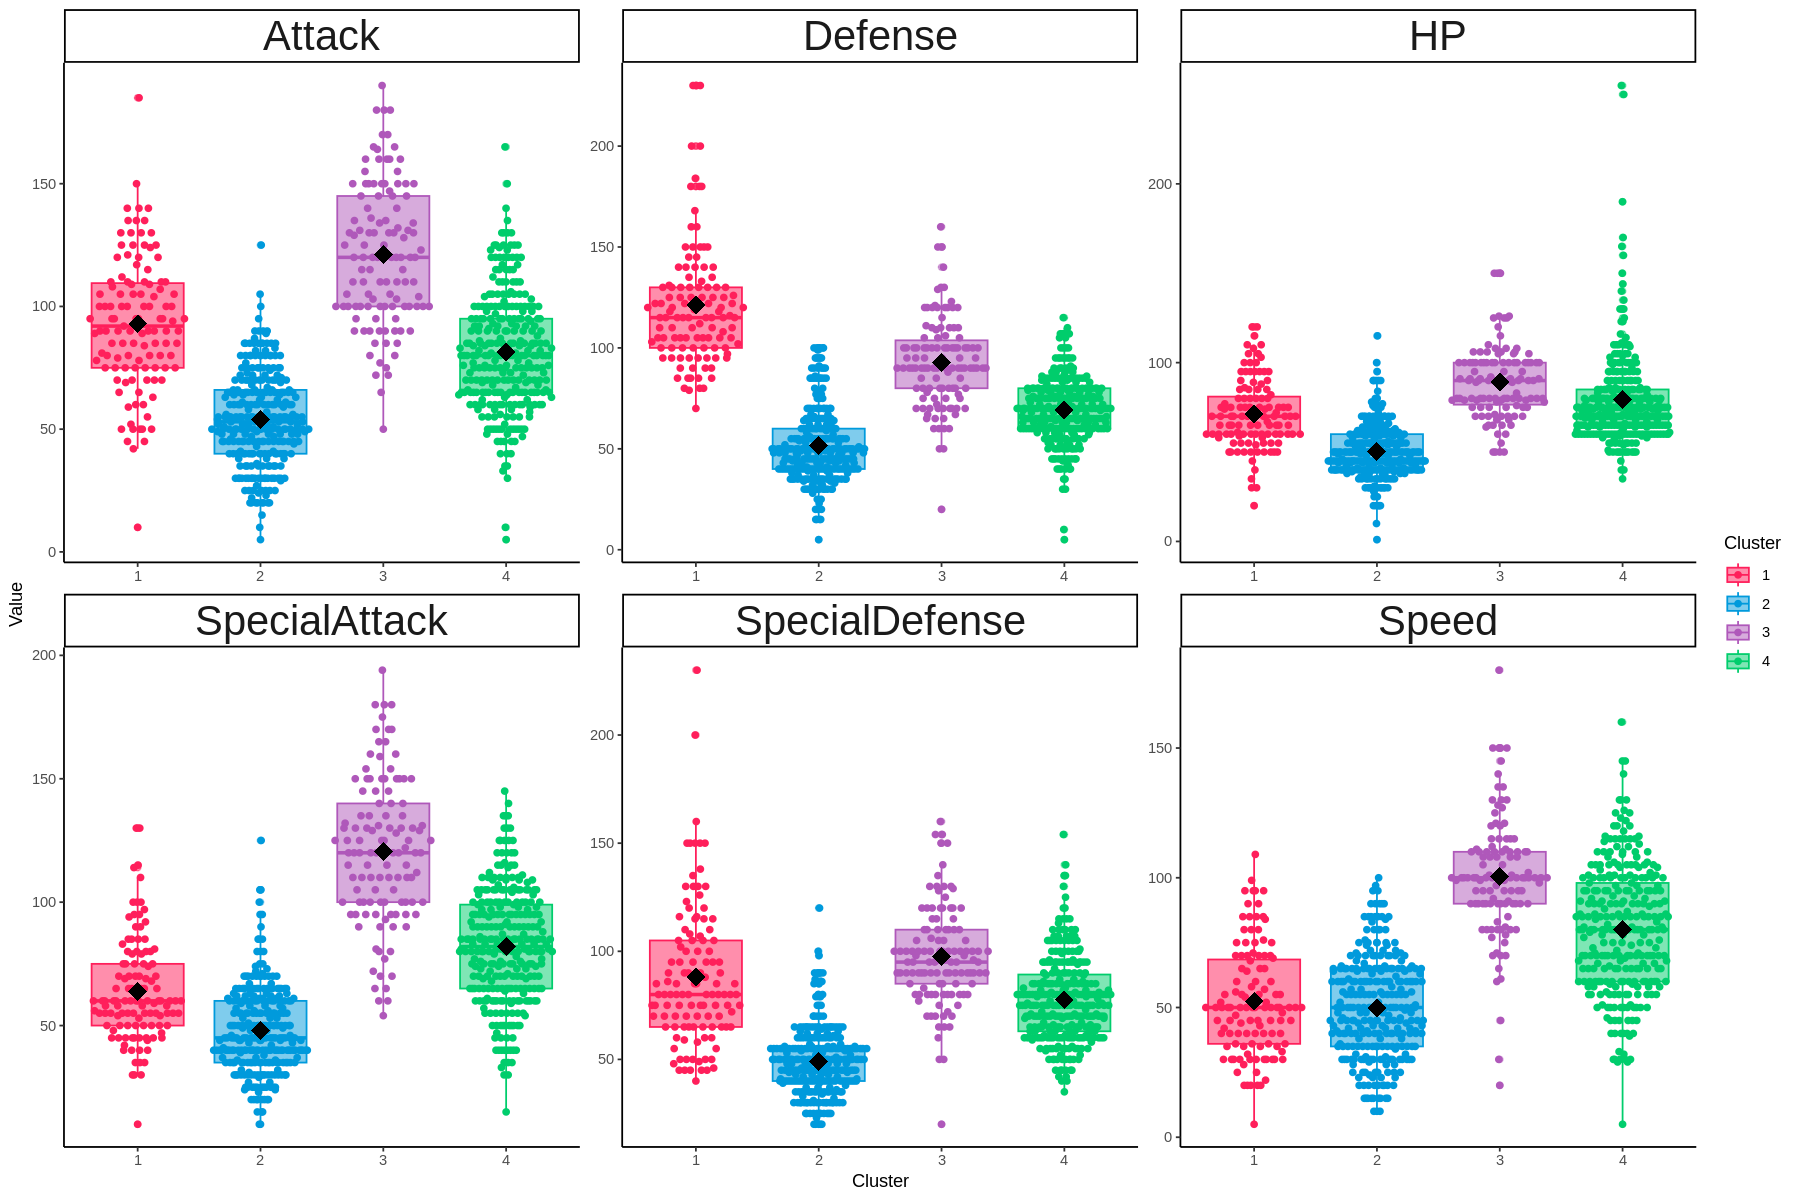

In [15]:
install.packages("tidyr")
install.packages("vipor")
install.packages("ggbeeswarm")

library(tidyr)
library(vipor)
library(ggbeeswarm)
options(repr.plot.width = 15, repr.plot.height = 10) # set dimensions of plots
Pokemon%>%
select(-c("Total","Type.1", "Type.2", "Legendary", "Generation","X." ))%>% # Select columns from the Pokemon data frame, excluding some columns like "Total," "Type.1," "Type.2,"
gather(key = Attribute, value = Value, -c("Name", "Cluster")) %>%
mutate(Cluster = as.factor(Cluster))%>%
ggplot(aes(x = Cluster, y = Value,  color = Cluster))+
geom_boxplot(alpha = 0.5, aes(fill = Cluster)) +
geom_quasirandom()+
facet_wrap(~Attribute, scales = "free") +
 scale_color_manual(values = c(
    '#FF1F5B',
    '#009ADC',
    '#AF58BA',
    '#00CD6C'
  )) +
 stat_summary(
    # add a symbol for the mean
    fun.y = mean,
    colour = "black",
    geom = "point",
    shape = 18,
    size = 5,
    position = position_dodge(width = .75),
    show.legend = FALSE
  ) +
 scale_fill_manual(values = c(
    '#FF1F5B',
    '#009ADC',
    '#AF58BA',
    '#00CD6C'
  )) +
theme_classic()+
theme(strip.text = element_text(size=25))

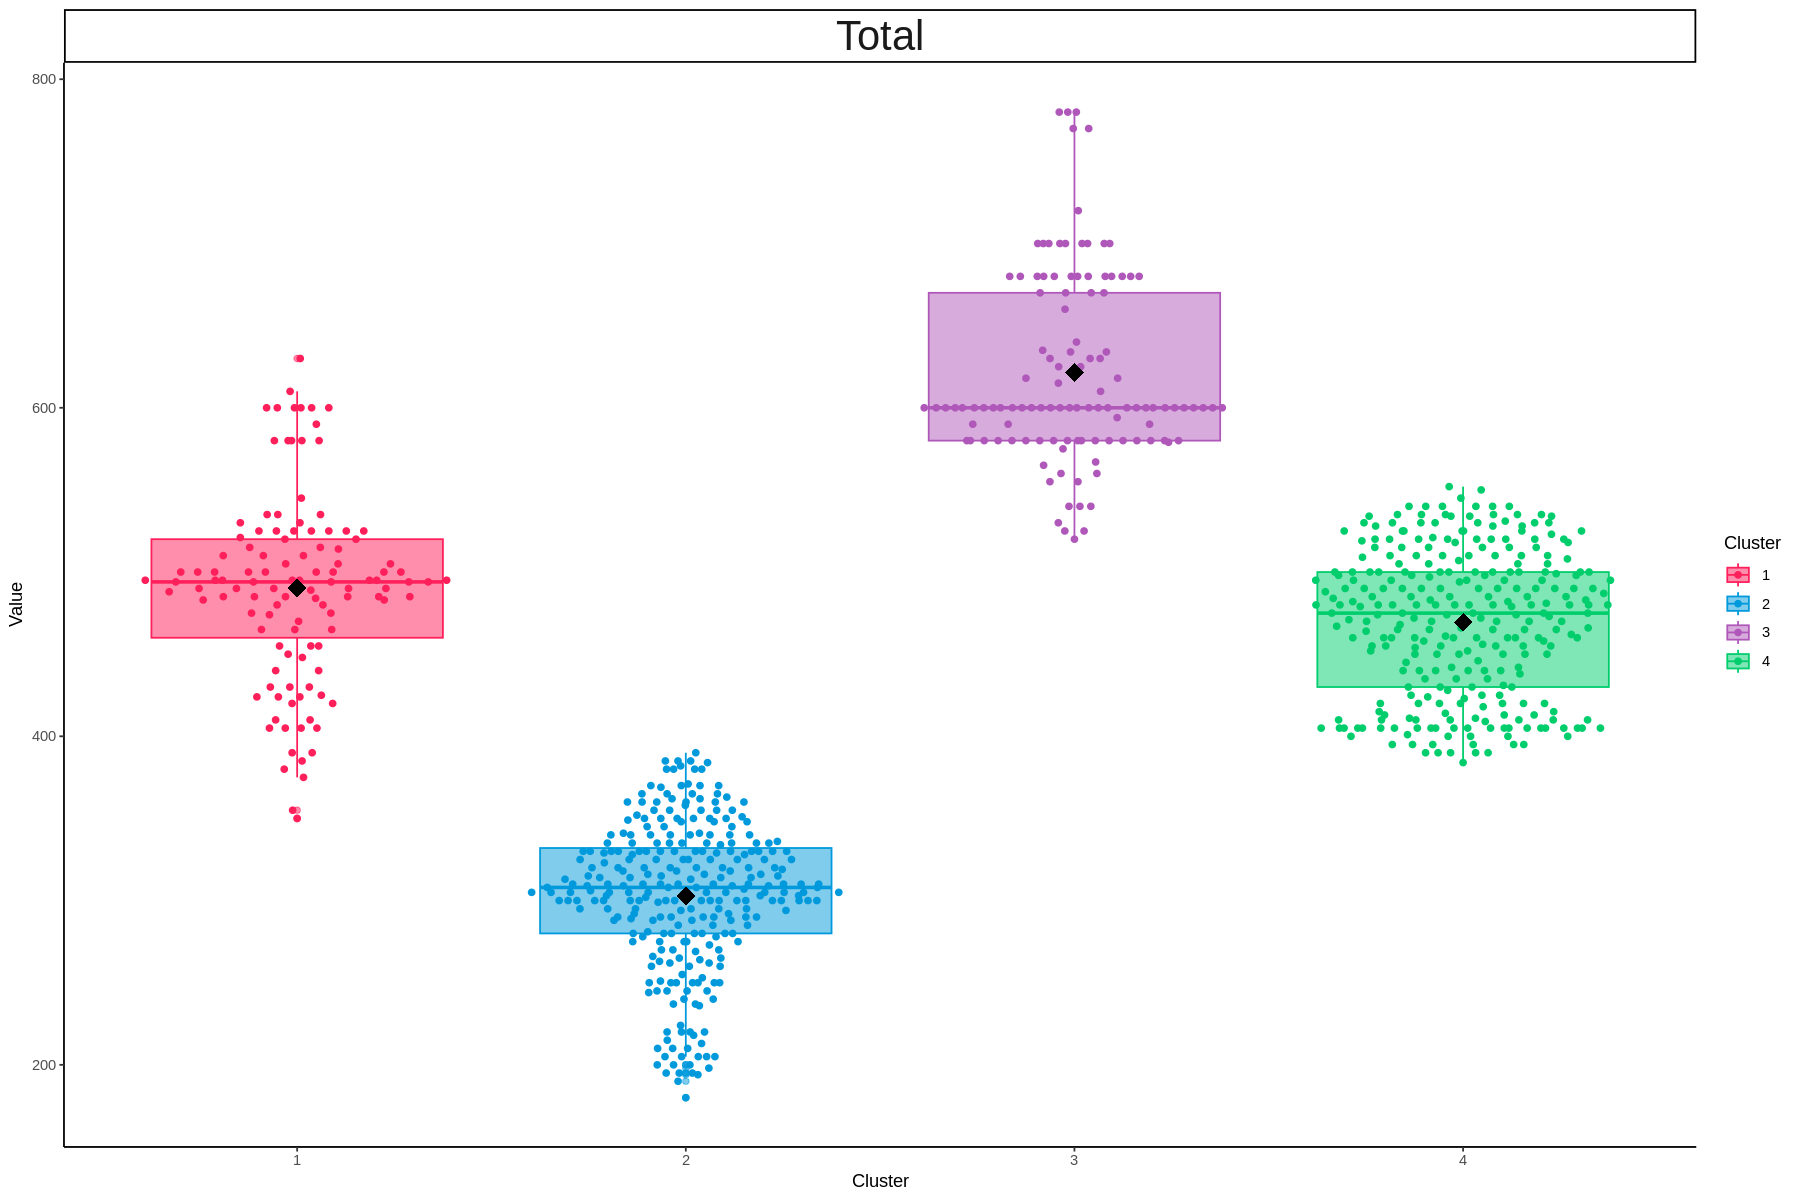

In [16]:
# Plot the cumulative score of all attributes ("Total")
options(repr.plot.width = 15, repr.plot.height = 10) # set dimensions of plots
Pokemon%>%
select(c("Name", "Cluster","Total"))%>%
gather(key = Attribute, value = Value, -c("Name", "Cluster")) %>% # transform the data into a long format, so that each attribute-value pair is in a separate row
mutate(Cluster = as.factor(Cluster))%>% # Convert the "Cluster" column to a factor
ggplot(aes(x = Cluster, y = Value,  color = Cluster))+
geom_boxplot(alpha = 0.5, aes(fill = Cluster)) +
geom_quasirandom()+
facet_wrap(~Attribute, scales = "free") +
 scale_color_manual(values = c(
    '#FF1F5B',
    '#009ADC',
    '#AF58BA',
    '#00CD6C'
  )) +
 scale_fill_manual(values = c(
    '#FF1F5B',
    '#009ADC',
    '#AF58BA',
    '#00CD6C'
  )) +
 stat_summary(
    # add a symbol for the mean
    fun.y = mean,
    colour = "black",
    geom = "point",
    shape = 18,
    size = 5,
    position = position_dodge(width = .75),
    show.legend = FALSE
  ) +
theme_classic()+
theme(strip.text = element_text(size=25))

##3. 🏆 Conclusion
1. We can use the provided traits to assign Pokemons to 4 clusters
2. Pokemon in cluster 2 appear to have the lowest trait values (on average) across features and are thus containing the weakest of the Pokemon. In Contrast the members of cluster 3 have the overall highes cummulative score (i.e. Total) and are thus containing the strongest Pokemon. Members of clusters 3 and 4 have higher Speed attributes than 1 and 2 and cluster 1 Pokemons score particularly high on Defense. Furthermore, cluster 3 Pokemon stand out by having the highes Attack and SpecialAttack values

In conclusion, the k-means cluster provides a useful tool to cluster Pokemon into meaningful categories that are charactersised by distinct trait profiles and strength levels